In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))
    

def evaluate_bh(pvals, labels, alpha):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]
    
    # Apply BH
    purity_test = len(idx_in)/len(pvals)
    reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

    # Evaluate FDP and Power
    rejections = np.sum(reject)
    if rejections > 0:
        fdp = np.sum(reject[idx_in])/reject.shape[0] 
        power = np.sum(reject[idx_out])/len(idx_out)
    else:
        fdp = 0
        power = 0
    return fdp, power

def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y, verbose=True):
    coverage, length, length_cover = evaluate_predictions(S, y)
    if verbose:
        print('Marginal coverage:       {:2.3%}'.format(coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y, verbose=True):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        if verbose:
            print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
            print('Average size:            {:2.3f}'.format(length))
            print('Average size | coverage: {:2.3f}'.format(length_cover))

In [3]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment 2: CES for multi-class classification

### Load CIFAR10 dataset

In [12]:
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Benchmark data-splitting vs CES data-splitting

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler

def split_data(seed, n_train_bm, n_val_bm, n_cal_bm, batch_size=10, num_workers=0):
    np.random.seed(seed)
    th.manual_seed(seed)

    # MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
    # Benchmark data splitting: equally split the data into 3 sets
    n_full = len(train_set)
    n_data = n_train_bm + n_val_bm + n_cal_bm

    train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                     [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

    # CES data splitting: calibration set is not needed, merge back to the training set
    n_train_ces = n_train_bm + n_val_bm
    n_val_ces = n_cal_bm

    train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                     [n_train_ces, n_val_ces, n_full-n_data])
    
    train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

    val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                              num_workers=num_workers)

    cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                              num_workers=num_workers)

    # For CES
    train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                              num_workers=num_workers)

    val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                              num_workers=num_workers)
    return train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces

def load_test(seed, n_test, num_workers=4):
    np.random.seed(seed)
    th.manual_seed(seed)

    test_sampler = SubsetRandomSampler(np.arange(n_test, dtype=np.int64))
    test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test, sampler=test_sampler,
                                             num_workers=num_workers)

    # get all test images
    dataiter = iter(test_loader)
    inputs, labels = dataiter.next()
    return inputs, labels

## Define experiment

In [6]:
import torch.optim as optim
from inference import Conformal_PVals
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet
from utils import eval_psets, eval_m_psets, eval_lc_psets



def run_experiment(seed, n_classes, n_train_bm, n_val_bm, n_cal_bm, n_test, lr, n_epoch, alpha, batch_size=64, num_worker=2, visualize=True):
    # Initialize result data frame
    results = pd.DataFrame({})
    
    # Get the dataloaders and test points
    train_loader_bm, val_loader_bm, cal_loader_bm, train_loader_ces, val_loader_ces =\
    split_data(seed, n_train_bm, n_val_bm, n_cal_bm, batch_size, num_worker)
    inputs, labels = load_test(seed, n_test)
    
    
    # Define default device, we should use the GPU (cuda) if available
    device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)
    if th.cuda.is_available():
        # Make CuDNN Determinist
        th.backends.cudnn.deterministic = True
        th.cuda.manual_seed(seed)
    # Set the NN parameters 
    net_bm = SimpleConvolutionalNetwork()
    Loss = th.nn.CrossEntropyLoss()
    def criterion(outputs, inputs, targets):
        return Loss(outputs, targets)
    optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)
    
    
    np.random.seed(seed)
    th.manual_seed(seed)
    
    # Train with benchmark data splitting
    print("Training with standard data splitting...")
    sys.stdout.flush()
    
    CES_mc_bm = CES_multiClass(net_bm, device, train_loader_bm, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)
    CES_mc_bm.full_train(save_dir = './models/multiClass/exp'+str(seed)+'/benchmarks/', save_every = 1)
    
    if visualize:
        plot_loss(CES_mc_bm.train_loss_history, CES_mc_bm.val_loss_history)
    
    # Compute the benchmark prediction sets
    print('Computing standard benchmark prediction sets for {:d} test points...'.format(n_test))
    sys.stdout.flush()
    
    best_loss_bm, best_model_bm, val_loss_history_bm = CES_mc_bm.select_model()
    model_list_bm = CES_mc_bm.model_list
    C_PSet_bm = Conformal_PSet(net_bm, device, cal_loader_bm, n_classes, model_list_bm, \
                           alpha, lc=False, random_state=seed)
    pset_m_bm= C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=True)
    results_bm = eval_m_psets(pset_m_bm, labels)
    results_bm["Method"] = "Standard benchmark"
    results = pd.concat([results, results_bm])
    
    
    np.random.seed(seed)
    th.manual_seed(seed)

    net_ces = SimpleConvolutionalNetwork()
    optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)
    
    # Initialize the CES class with model parameters
    print("Training with CES data splitting...")
    sys.stdout.flush()
    
    CES_mc_ces = CES_multiClass(net_ces, device, train_loader_ces, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)
    CES_mc_ces.full_train(save_dir = './models/multiClass/exp'+str(seed)+'/ces/', save_every = 1)
    
    if visualize:
        plot_loss(CES_mc_ces.train_loss_history, CES_mc_ces.val_loss_history)
    

    # Compute the benchmark prediction sets
    print('Computing naive benchmark prediction sets for {:d} test points...'.format(n_test))
    best_loss_naive, best_model_naive, val_loss_history_naive = CES_mc_ces.select_model()
    model_list_ces = CES_mc_ces.model_list
    C_PSet_ces = Conformal_PSet(net_ces, device, val_loader_ces, n_classes, model_list_ces, \
                           alpha, lc=False, random_state = seed) 
    pset_m_naive= C_PSet_ces.pred_set(inputs, [[best_model_naive]*n_classes]*len(inputs), marginal=True)
    results_naive = eval_m_psets(pset_m_naive, labels)
    results_naive["Method"] = "Naive benchmark"
    results = pd.concat([results, results_naive])
    
    return results



Starting repetition 1 of 10:

Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.30 train_acc: 10.94% took: 11.53s
Epoch 1 of 15, 12% 	 train_loss: 134478496.00 train_acc: 7.81% took: 0.05s
Epoch 1 of 15, 18% 	 train_loss: 35969652.00 train_acc: 6.25% took: 0.05s
Epoch 1 of 15, 25% 	 train_loss: 114488056.00 train_acc: 15.62% took: 0.05s
Epoch 1 of 15, 31% 	 train_loss: 93390720.00 train_acc: 12.50% took: 0.05s
Epoch 1 of 15, 37% 	 train_loss: 46770768.00 train_acc: 9.38% took: 0.05s
Epoch 1 of 15, 43% 	 train_loss: 39750628.00 train_acc: 3.12% took: 0.05s
Epoch 1 of 15, 50% 	 train_loss: 40567708.00 train_acc: 9.38% took: 0.05s
Epoch 1 of 15, 56% 	 train_loss: 20324282.00 train_acc: 10.94% took: 0.05s
Epoch 1 of 15, 62% 	 train_loss: 9283404.00 train_acc: 4.69% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 7569308.00 train_acc: 6.25% took: 0.05s
Epoch 1 of 15, 75% 	 train_loss: 5917913.50

val_loss = 2.61 val_acc = 8.80%
Snapshot saved at epoch 7.
Epoch 8 of 15, 6% 	 train_loss: 2.58 train_acc: 7.81% took: 11.05s
Epoch 8 of 15, 12% 	 train_loss: 2.56 train_acc: 7.81% took: 0.05s
Epoch 8 of 15, 18% 	 train_loss: 2.51 train_acc: 7.81% took: 0.06s
Epoch 8 of 15, 25% 	 train_loss: 2.63 train_acc: 10.94% took: 0.05s
Epoch 8 of 15, 31% 	 train_loss: 2.87 train_acc: 7.81% took: 0.06s
Epoch 8 of 15, 37% 	 train_loss: 2.77 train_acc: 14.06% took: 0.05s
Epoch 8 of 15, 43% 	 train_loss: 2.58 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 50% 	 train_loss: 2.65 train_acc: 14.06% took: 0.05s
Epoch 8 of 15, 56% 	 train_loss: 2.75 train_acc: 6.25% took: 0.05s
Epoch 8 of 15, 62% 	 train_loss: 2.56 train_acc: 4.69% took: 0.05s
Epoch 8 of 15, 68% 	 train_loss: 2.43 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 3.05 train_acc: 10.94% took: 0.06s
Epoch 8 of 15, 81% 	 train_loss: 3.06 train_acc: 7.81% took: 0.05s
Epoch 8 of 15, 87% 	 train_loss: 2.89 train_acc: 6.25% took: 0.0

Epoch 15 of 15, 31% 	 train_loss: 2.94 train_acc: 7.81% took: 0.05s
Epoch 15 of 15, 37% 	 train_loss: 3.29 train_acc: 14.06% took: 0.06s
Epoch 15 of 15, 43% 	 train_loss: 2.71 train_acc: 9.38% took: 0.06s
Epoch 15 of 15, 50% 	 train_loss: 3.01 train_acc: 14.06% took: 0.06s
Epoch 15 of 15, 56% 	 train_loss: 2.82 train_acc: 12.50% took: 0.06s
Epoch 15 of 15, 62% 	 train_loss: 2.90 train_acc: 15.62% took: 0.05s
Epoch 15 of 15, 68% 	 train_loss: 2.72 train_acc: 9.38% took: 0.07s
Epoch 15 of 15, 75% 	 train_loss: 3.32 train_acc: 9.38% took: 0.06s
Epoch 15 of 15, 81% 	 train_loss: 3.29 train_acc: 7.81% took: 0.05s
Epoch 15 of 15, 87% 	 train_loss: 3.13 train_acc: 6.25% took: 0.05s
Epoch 15 of 15, 93% 	 train_loss: 2.80 train_acc: 10.94% took: 0.05s
Epoch 15 of 15, 100% 	 train_loss: 3.56 train_acc: 5.00% took: 0.04s
val_loss = 3.11 val_acc = 8.80%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


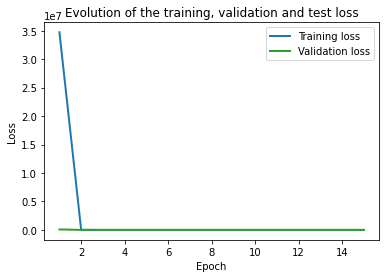

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:20<00:00,  5.33s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.58it/s]


Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 69649177.15 train_acc: 12.50% took: 5.56s
Epoch 1 of 15, 16% 	 train_loss: 123860692.00 train_acc: 7.03% took: 0.13s
Epoch 1 of 15, 25% 	 train_loss: 62412868.00 train_acc: 13.28% took: 0.10s
Epoch 1 of 15, 33% 	 train_loss: 29238082.00 train_acc: 9.38% took: 0.12s
Epoch 1 of 15, 41% 	 train_loss: 24991953.00 train_acc: 10.94% took: 0.11s
Epoch 1 of 15, 50% 	 train_loss: 8376065.06 train_acc: 9.38% took: 0.14s
Epoch 1 of 15, 58% 	 train_loss: 123103.32 train_acc: 7.81% took: 0.11s
Epoch 1 of 15, 66% 	 train_loss: 108782.28 train_acc: 11.72% took: 0.11s
Epoch 1 of 15, 75% 	 train_loss: 89079.97 train_acc: 9.38% took: 0.13s
Epoch 1 of 15, 83% 	 train_loss: 2158.54 train_acc: 7.03% took: 0.12s
Epoch 1 of 15, 91% 	 train_loss: 218001.48 train_acc: 5.47% took: 0.12s
Epoch 1 of 15, 100% 	

Epoch 10 of 15, 25% 	 train_loss: 2.76 train_acc: 4.69% took: 0.11s
Epoch 10 of 15, 33% 	 train_loss: 2.52 train_acc: 14.84% took: 0.10s
Epoch 10 of 15, 41% 	 train_loss: 2.84 train_acc: 9.38% took: 0.11s
Epoch 10 of 15, 50% 	 train_loss: 2.60 train_acc: 10.16% took: 0.10s
Epoch 10 of 15, 58% 	 train_loss: 2.83 train_acc: 12.50% took: 0.11s
Epoch 10 of 15, 66% 	 train_loss: 2.66 train_acc: 11.72% took: 0.11s
Epoch 10 of 15, 75% 	 train_loss: 2.46 train_acc: 16.41% took: 0.10s
Epoch 10 of 15, 83% 	 train_loss: 2.56 train_acc: 11.72% took: 0.07s
Epoch 10 of 15, 91% 	 train_loss: 2.55 train_acc: 14.84% took: 0.10s
Epoch 10 of 15, 100% 	 train_loss: 2.49 train_acc: 12.39% took: 0.06s
val_loss = 2.74 val_acc = 13.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.72 train_acc: 12.50% took: 5.92s
Epoch 11 of 15, 16% 	 train_loss: 2.45 train_acc: 8.59% took: 0.11s
Epoch 11 of 15, 25% 	 train_loss: 2.76 train_acc: 6.25% took: 0.11s
Epoch 11 of 15, 33% 	 train_loss: 2.50 train_a

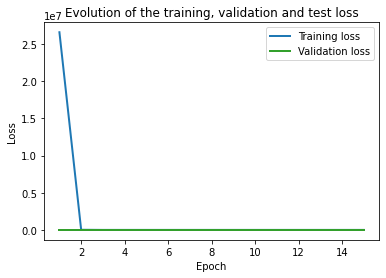

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:17<00:00,  5.16s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.16it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 2 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.30 train_acc: 12.50% took: 4.57s
Epoch 1 of 15, 12% 	 train_loss: 133462408.00 train_acc: 7.81% took: 0.05s
Epoch 1 of 15, 18% 	 train_loss: 93747272.00 train_acc: 9.38% took: 0.05s
Epoch 1 of 15, 25% 	 train_loss: 80957920.00 train_acc: 15.62% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 96676440.00 train_acc: 10.94% took: 0.04s
Epoch 1 of 15, 37% 	 train_loss: 87711376.00 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 64245820.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 47528116.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 17968688.00 train_acc: 17.19% took: 0.03s
Epoch 1 of 15, 62% 	 train_loss: 3491687.00 train_acc: 7.81% took: 0.03s
Epoch 1 of 15, 68% 	 train_loss: 2649279.00 train_acc: 6.25% took: 0.03s
Epoch 1 of 15, 75% 	 train_loss: 2649183.50 train_acc: 15.62% took: 0.07s
E

Epoch 8 of 15, 6% 	 train_loss: 2.75 train_acc: 7.81% took: 5.48s
Epoch 8 of 15, 12% 	 train_loss: 2.74 train_acc: 7.81% took: 0.06s
Epoch 8 of 15, 18% 	 train_loss: 2.65 train_acc: 7.81% took: 0.07s
Epoch 8 of 15, 25% 	 train_loss: 2.59 train_acc: 6.25% took: 0.06s
Epoch 8 of 15, 31% 	 train_loss: 2.63 train_acc: 7.81% took: 0.07s
Epoch 8 of 15, 37% 	 train_loss: 2.74 train_acc: 12.50% took: 0.05s
Epoch 8 of 15, 43% 	 train_loss: 2.65 train_acc: 3.12% took: 0.05s
Epoch 8 of 15, 50% 	 train_loss: 2.82 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 56% 	 train_loss: 2.91 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.91 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 2.45 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 2.65 train_acc: 15.62% took: 0.04s
Epoch 8 of 15, 81% 	 train_loss: 2.74 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 3.13 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 93% 	 train_loss: 3.03 train_acc: 7.81% to

Epoch 15 of 15, 37% 	 train_loss: 2.99 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 43% 	 train_loss: 2.71 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 50% 	 train_loss: 3.08 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 56% 	 train_loss: 2.92 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 2.64 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 2.74 train_acc: 17.19% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 2.64 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 2.53 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 3.34 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 3.12 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.90 train_acc: 10.00% took: 0.03s
val_loss = 2.72 val_acc = 9.80%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


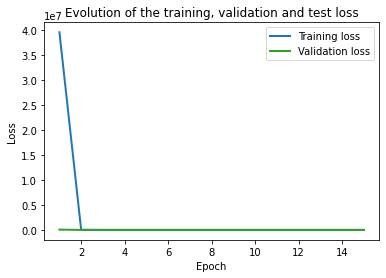

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.55s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.39it/s]


Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 152344545.17 train_acc: 12.50% took: 3.61s
Epoch 1 of 15, 16% 	 train_loss: 31190051.00 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 52865982.00 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 4056395.00 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 48808.10 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 21.16 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 16.18 train_acc: 10.94% took: 0.08s
Epoch 1 of 15, 66% 	 train_loss: 13.48 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 9.04 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 79530.70 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 103140.95 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 100% 	 train_loss: 6.19

Epoch 10 of 15, 25% 	 train_loss: 3.13 train_acc: 7.81% took: 0.11s
Epoch 10 of 15, 33% 	 train_loss: 2.97 train_acc: 11.72% took: 0.11s
Epoch 10 of 15, 41% 	 train_loss: 2.85 train_acc: 9.38% took: 0.09s
Epoch 10 of 15, 50% 	 train_loss: 2.73 train_acc: 11.72% took: 0.09s
Epoch 10 of 15, 58% 	 train_loss: 2.95 train_acc: 7.81% took: 0.08s
Epoch 10 of 15, 66% 	 train_loss: 2.82 train_acc: 9.38% took: 0.08s
Epoch 10 of 15, 75% 	 train_loss: 2.57 train_acc: 7.03% took: 0.07s
Epoch 10 of 15, 83% 	 train_loss: 2.84 train_acc: 12.50% took: 0.08s
Epoch 10 of 15, 91% 	 train_loss: 2.67 train_acc: 12.50% took: 0.07s
Epoch 10 of 15, 100% 	 train_loss: 2.77 train_acc: 11.61% took: 0.06s
val_loss = 2.70 val_acc = 15.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.77 train_acc: 6.25% took: 4.78s
Epoch 11 of 15, 16% 	 train_loss: 2.81 train_acc: 9.38% took: 0.09s
Epoch 11 of 15, 25% 	 train_loss: 3.02 train_acc: 7.81% took: 0.13s
Epoch 11 of 15, 33% 	 train_loss: 2.78 train_acc: 

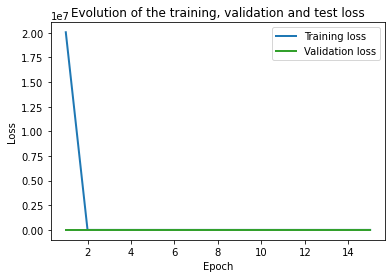

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.04s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.23it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 3 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.30 train_acc: 12.50% took: 3.66s
Epoch 1 of 15, 12% 	 train_loss: 192326816.00 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 18% 	 train_loss: 31030214.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 25% 	 train_loss: 60212836.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 65413920.00 train_acc: 12.50% took: 0.03s
Epoch 1 of 15, 37% 	 train_loss: 48846600.00 train_acc: 10.94% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 16298766.00 train_acc: 17.19% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 1663587.00 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 464068.31 train_acc: 17.19% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 4102735.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 54706.46 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 30.86 train_acc: 17.19% took: 0.04s
Epoch 1 

Epoch 8 of 15, 6% 	 train_loss: 2.57 train_acc: 9.38% took: 4.25s
Epoch 8 of 15, 12% 	 train_loss: 2.90 train_acc: 7.81% took: 0.08s
Epoch 8 of 15, 18% 	 train_loss: 2.94 train_acc: 9.38% took: 0.06s
Epoch 8 of 15, 25% 	 train_loss: 2.71 train_acc: 12.50% took: 0.05s
Epoch 8 of 15, 31% 	 train_loss: 2.68 train_acc: 12.50% took: 0.05s
Epoch 8 of 15, 37% 	 train_loss: 2.75 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 43% 	 train_loss: 2.87 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 50% 	 train_loss: 2.95 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 56% 	 train_loss: 3.03 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.79 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 2.73 train_acc: 1.56% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 2.71 train_acc: 4.69% took: 0.04s
Epoch 8 of 15, 81% 	 train_loss: 2.80 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.77 train_acc: 6.25% took: 0.06s
Epoch 8 of 15, 93% 	 train_loss: 2.81 train_acc: 10.94% took

Epoch 15 of 15, 31% 	 train_loss: 2.88 train_acc: 12.50% took: 0.06s
Epoch 15 of 15, 37% 	 train_loss: 2.94 train_acc: 7.81% took: 0.06s
Epoch 15 of 15, 43% 	 train_loss: 3.14 train_acc: 12.50% took: 0.07s
Epoch 15 of 15, 50% 	 train_loss: 3.16 train_acc: 9.38% took: 0.06s
Epoch 15 of 15, 56% 	 train_loss: 3.32 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 3.09 train_acc: 9.38% took: 0.05s
Epoch 15 of 15, 68% 	 train_loss: 2.89 train_acc: 1.56% took: 0.06s
Epoch 15 of 15, 75% 	 train_loss: 2.77 train_acc: 4.69% took: 0.06s
Epoch 15 of 15, 81% 	 train_loss: 3.08 train_acc: 6.25% took: 0.06s
Epoch 15 of 15, 87% 	 train_loss: 3.04 train_acc: 9.38% took: 0.05s
Epoch 15 of 15, 93% 	 train_loss: 3.17 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.98 train_acc: 15.00% took: 0.03s
val_loss = 2.98 val_acc = 10.20%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


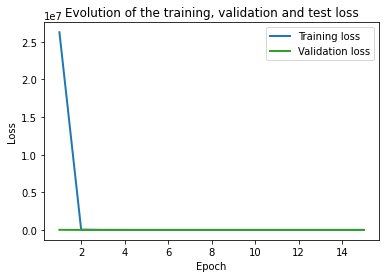

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.44s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.85it/s]

Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...


===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 108613609.15 train_acc: 7.81% took: 3.61s
Epoch 1 of 15, 16% 	 train_loss: 89952640.00 train_acc: 9.38% took: 0.06s
Epoch 1 of 15, 25% 	 train_loss: 86362936.00 train_acc: 12.50% took: 0.06s
Epoch 1 of 15, 33% 	 train_loss: 31688334.00 train_acc: 12.50% took: 0.06s
Epoch 1 of 15, 41% 	 train_loss: 29271858.50 train_acc: 13.28% took: 0.06s
Epoch 1 of 15, 50% 	 train_loss: 7157949.00 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 6700296.31 train_acc: 11.72% took: 0.06s
Epoch 1 of 15, 66% 	 train_loss: 2013231.94 train_acc: 6.25% took: 0.06s
Epoch 1 of 15, 75% 	 train_loss: 1757873.50 train_acc: 10.16% took: 0.06s
Epoch 1 of 15, 83% 	 train_loss: 1288954.03 train_acc: 14.84% took: 0.06s
Epoch 1 of 15, 91% 	 train_loss: 1361518.56 train_acc: 10.16% took: 0.06s
Epoch 1 of 15, 100% 	 train_loss: 964131.53 train_acc: 8.48% took: 0.05s
val_loss = 631648.25 val_acc = 13.00%

Epoch 10 of 15, 33% 	 train_loss: 2.76 train_acc: 10.16% took: 0.07s
Epoch 10 of 15, 41% 	 train_loss: 2.78 train_acc: 14.06% took: 0.07s
Epoch 10 of 15, 50% 	 train_loss: 2.63 train_acc: 10.16% took: 0.07s
Epoch 10 of 15, 58% 	 train_loss: 2.85 train_acc: 8.59% took: 0.07s
Epoch 10 of 15, 66% 	 train_loss: 3.72 train_acc: 13.28% took: 0.07s
Epoch 10 of 15, 75% 	 train_loss: 2.97 train_acc: 7.81% took: 0.07s
Epoch 10 of 15, 83% 	 train_loss: 2.57 train_acc: 10.94% took: 0.07s
Epoch 10 of 15, 91% 	 train_loss: 45.86 train_acc: 7.03% took: 0.07s
Epoch 10 of 15, 100% 	 train_loss: 2.73 train_acc: 10.04% took: 0.06s
val_loss = 2.73 val_acc = 16.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 3.02 train_acc: 10.16% took: 4.81s
Epoch 11 of 15, 16% 	 train_loss: 2.77 train_acc: 9.38% took: 0.11s
Epoch 11 of 15, 25% 	 train_loss: 2.70 train_acc: 9.38% took: 0.12s
Epoch 11 of 15, 33% 	 train_loss: 2.61 train_acc: 9.38% took: 0.09s
Epoch 11 of 15, 41% 	 train_loss: 2.59 train_ac

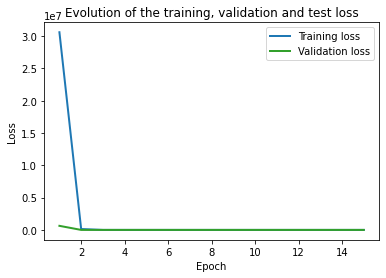

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.23s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.98it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 4 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.30 train_acc: 12.50% took: 3.58s
Epoch 1 of 15, 12% 	 train_loss: 106149328.00 train_acc: 7.81% took: 0.03s
Epoch 1 of 15, 18% 	 train_loss: 101475728.00 train_acc: 12.50% took: 0.03s
Epoch 1 of 15, 25% 	 train_loss: 75422976.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 116852016.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 37% 	 train_loss: 75750128.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 27372578.00 train_acc: 12.50% took: 0.03s
Epoch 1 of 15, 50% 	 train_loss: 20948736.00 train_acc: 15.62% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 22226948.00 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 1822645.62 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 435881.47 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 134455.78 train_acc: 14.06% took: 0.04s
E

Epoch 8 of 15, 6% 	 train_loss: 2.58 train_acc: 6.25% took: 3.46s
Epoch 8 of 15, 12% 	 train_loss: 2.53 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 18% 	 train_loss: 2.47 train_acc: 14.06% took: 0.04s
Epoch 8 of 15, 25% 	 train_loss: 2.50 train_acc: 14.06% took: 0.04s
Epoch 8 of 15, 31% 	 train_loss: 2.70 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 37% 	 train_loss: 2.79 train_acc: 9.38% took: 0.03s
Epoch 8 of 15, 43% 	 train_loss: 2.62 train_acc: 14.06% took: 0.04s
Epoch 8 of 15, 50% 	 train_loss: 2.45 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 56% 	 train_loss: 2.53 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.66 train_acc: 4.69% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 2.60 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 75% 	 train_loss: 2.61 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 81% 	 train_loss: 2.80 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.57 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 93% 	 train_loss: 2.71 train_acc: 6.25% 

Epoch 15 of 15, 31% 	 train_loss: 2.84 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 37% 	 train_loss: 2.80 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 43% 	 train_loss: 2.49 train_acc: 7.81% took: 0.05s
Epoch 15 of 15, 50% 	 train_loss: 2.34 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 56% 	 train_loss: 2.42 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 2.60 train_acc: 4.69% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 2.36 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 2.53 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 2.75 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 2.54 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.52 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.61 train_acc: 7.50% took: 0.03s
val_loss = 2.46 val_acc = 9.80%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


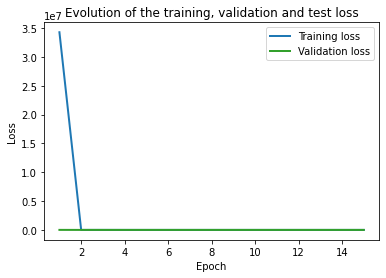

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.25s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.98it/s]


Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 69667825.15 train_acc: 10.16% took: 3.71s
Epoch 1 of 15, 16% 	 train_loss: 86956958.00 train_acc: 8.59% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 96456304.00 train_acc: 6.25% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 25119899.00 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 31274554.00 train_acc: 10.16% took: 0.08s
Epoch 1 of 15, 50% 	 train_loss: 4168712.62 train_acc: 13.28% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 1112806.12 train_acc: 18.75% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 708622.35 train_acc: 14.84% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 69721.89 train_acc: 6.25% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 70243.96 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 195911.70 train_acc: 11.72% took: 0.07s
Epoch 1 of 15, 10

Epoch 10 of 15, 33% 	 train_loss: 2.95 train_acc: 17.97% took: 0.07s
Epoch 10 of 15, 41% 	 train_loss: 2.91 train_acc: 8.59% took: 0.07s
Epoch 10 of 15, 50% 	 train_loss: 3.21 train_acc: 7.03% took: 0.07s
Epoch 10 of 15, 58% 	 train_loss: 2.88 train_acc: 7.81% took: 0.06s
Epoch 10 of 15, 66% 	 train_loss: 2.91 train_acc: 5.47% took: 0.07s
Epoch 10 of 15, 75% 	 train_loss: 3.46 train_acc: 10.16% took: 0.07s
Epoch 10 of 15, 83% 	 train_loss: 3.24 train_acc: 7.81% took: 0.07s
Epoch 10 of 15, 91% 	 train_loss: 2.72 train_acc: 13.28% took: 0.07s
Epoch 10 of 15, 100% 	 train_loss: 2.92 train_acc: 9.04% took: 0.06s
val_loss = 2.97 val_acc = 12.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 3.11 train_acc: 9.38% took: 3.73s
Epoch 11 of 15, 16% 	 train_loss: 3.38 train_acc: 6.25% took: 0.07s
Epoch 11 of 15, 25% 	 train_loss: 3.19 train_acc: 9.38% took: 0.07s
Epoch 11 of 15, 33% 	 train_loss: 3.14 train_acc: 13.28% took: 0.07s
Epoch 11 of 15, 41% 	 train_loss: 2.92 train_acc: 8

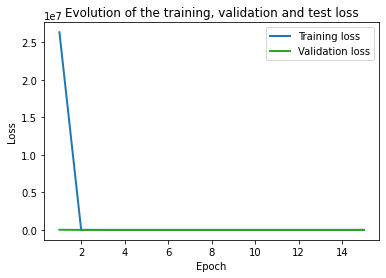

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.53s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.39it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 5 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.31 train_acc: 9.38% took: 3.79s
Epoch 1 of 15, 12% 	 train_loss: 145477200.00 train_acc: 12.50% took: 0.03s
Epoch 1 of 15, 18% 	 train_loss: 32908600.00 train_acc: 10.94% took: 0.03s
Epoch 1 of 15, 25% 	 train_loss: 109429552.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 50559472.00 train_acc: 15.62% took: 0.03s
Epoch 1 of 15, 37% 	 train_loss: 68095488.00 train_acc: 4.69% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 13861902.00 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 9929753.00 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 14692261.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 7087568.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 1435364.75 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 643468.69 train_acc: 12.50% took: 0.04s
Ep

Epoch 8 of 15, 6% 	 train_loss: 2.90 train_acc: 4.69% took: 3.92s
Epoch 8 of 15, 12% 	 train_loss: 2.56 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 18% 	 train_loss: 2.73 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 25% 	 train_loss: 2.63 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 31% 	 train_loss: 2.65 train_acc: 3.12% took: 0.04s
Epoch 8 of 15, 37% 	 train_loss: 2.54 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 43% 	 train_loss: 2.89 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 50% 	 train_loss: 2.62 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 56% 	 train_loss: 2.68 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.57 train_acc: 3.12% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 2.82 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 2.62 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 81% 	 train_loss: 2.87 train_acc: 14.06% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.63 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 93% 	 train_loss: 2.62 train_acc: 10.94% took

Epoch 15 of 15, 31% 	 train_loss: 2.93 train_acc: 3.12% took: 0.07s
Epoch 15 of 15, 37% 	 train_loss: 2.79 train_acc: 7.81% took: 0.08s
Epoch 15 of 15, 43% 	 train_loss: 2.83 train_acc: 12.50% took: 0.10s
Epoch 15 of 15, 50% 	 train_loss: 2.75 train_acc: 10.94% took: 0.07s
Epoch 15 of 15, 56% 	 train_loss: 2.44 train_acc: 12.50% took: 0.06s
Epoch 15 of 15, 62% 	 train_loss: 2.77 train_acc: 15.62% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 2.81 train_acc: 15.62% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 2.60 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 2.72 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 2.66 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.53 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.32 train_acc: 17.50% took: 0.03s
val_loss = 2.91 val_acc = 10.20%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


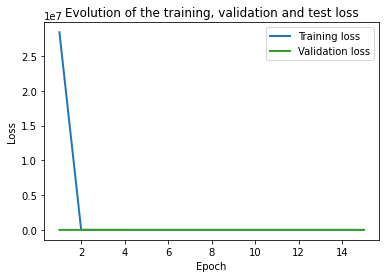

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.95s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.44it/s]

Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...


===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 133199441.16 train_acc: 2.34% took: 3.48s
Epoch 1 of 15, 16% 	 train_loss: 91397128.00 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 139504724.00 train_acc: 11.72% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 8976778.75 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 3728642.47 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 354.44 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 415165.91 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 24.55 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 22.34 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 17.07 train_acc: 6.25% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 9.44 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 100% 	 train_loss: 6.85 train_acc: 9.26% took: 0.07s
val_loss = 8.13 val_acc = 8.00%
Snapshot saved at epoch 1.
Epoch 2 of 

Epoch 10 of 15, 50% 	 train_loss: 2.61 train_acc: 6.25% took: 0.09s
Epoch 10 of 15, 58% 	 train_loss: 2.61 train_acc: 10.94% took: 0.09s
Epoch 10 of 15, 66% 	 train_loss: 2.65 train_acc: 11.72% took: 0.09s
Epoch 10 of 15, 75% 	 train_loss: 2.76 train_acc: 11.72% took: 0.09s
Epoch 10 of 15, 83% 	 train_loss: 2.67 train_acc: 8.59% took: 0.09s
Epoch 10 of 15, 91% 	 train_loss: 2.78 train_acc: 15.62% took: 0.09s
Epoch 10 of 15, 100% 	 train_loss: 2.76 train_acc: 11.27% took: 0.07s
val_loss = 2.88 val_acc = 12.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.82 train_acc: 13.28% took: 3.57s
Epoch 11 of 15, 16% 	 train_loss: 2.79 train_acc: 5.47% took: 0.07s
Epoch 11 of 15, 25% 	 train_loss: 2.77 train_acc: 10.94% took: 0.07s
Epoch 11 of 15, 33% 	 train_loss: 2.48 train_acc: 7.03% took: 0.07s
Epoch 11 of 15, 41% 	 train_loss: 2.84 train_acc: 8.59% took: 0.07s
Epoch 11 of 15, 50% 	 train_loss: 2.82 train_acc: 7.81% took: 0.07s
Epoch 11 of 15, 58% 	 train_loss: 2.66 train_acc

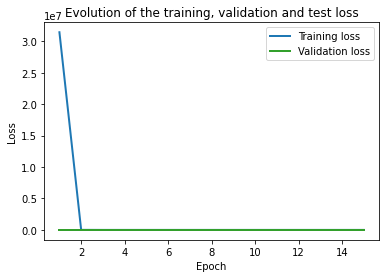

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.46s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.04it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 6 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.31 train_acc: 7.81% took: 3.73s
Epoch 1 of 15, 12% 	 train_loss: 152163168.00 train_acc: 6.25% took: 0.02s
Epoch 1 of 15, 18% 	 train_loss: 96998584.00 train_acc: 3.12% took: 0.03s
Epoch 1 of 15, 25% 	 train_loss: 147459536.00 train_acc: 6.25% took: 0.03s
Epoch 1 of 15, 31% 	 train_loss: 233600064.00 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 37% 	 train_loss: 51542616.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 31061882.00 train_acc: 10.94% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 71083168.00 train_acc: 20.31% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 54038240.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 9981432.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 2003734.75 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 919097.56 train_acc: 9.38% took: 0.03s
Epo

val_loss = 5001.69 val_acc = 10.20%
Snapshot saved at epoch 7.
Epoch 8 of 15, 6% 	 train_loss: 2.34 train_acc: 9.38% took: 3.70s
Epoch 8 of 15, 12% 	 train_loss: 2.52 train_acc: 7.81% took: 0.03s
Epoch 8 of 15, 18% 	 train_loss: 2.44 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 25% 	 train_loss: 70.52 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 31% 	 train_loss: 2.77 train_acc: 3.12% took: 0.04s
Epoch 8 of 15, 37% 	 train_loss: 2.42 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 43% 	 train_loss: 2.66 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 50% 	 train_loss: 2.72 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 56% 	 train_loss: 2.47 train_acc: 7.81% took: 0.03s
Epoch 8 of 15, 62% 	 train_loss: 2.44 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 2.62 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 2.53 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 81% 	 train_loss: 2.34 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 5.83 train_acc: 9.38% took: 

Epoch 15 of 15, 31% 	 train_loss: 2.98 train_acc: 3.12% took: 0.04s
Epoch 15 of 15, 37% 	 train_loss: 2.64 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 43% 	 train_loss: 2.99 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 50% 	 train_loss: 2.82 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 56% 	 train_loss: 2.53 train_acc: 17.19% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 2.70 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 2.76 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 2.71 train_acc: 3.12% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 2.60 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 2.52 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.31 train_acc: 23.44% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.78 train_acc: 7.50% took: 0.03s
val_loss = 4941.24 val_acc = 10.20%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


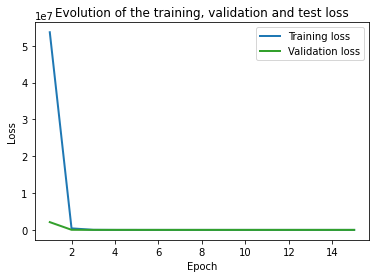

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.44s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.61it/s]

Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...


===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 56961969.15 train_acc: 12.50% took: 3.48s
Epoch 1 of 15, 16% 	 train_loss: 73234084.00 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 53123540.50 train_acc: 7.03% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 20253034.00 train_acc: 4.69% took: 0.08s
Epoch 1 of 15, 41% 	 train_loss: 17498170.50 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 3790161.62 train_acc: 13.28% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 1764425.44 train_acc: 17.97% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 1258659.88 train_acc: 14.06% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 3065187.62 train_acc: 8.59% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 1261913.31 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 653094.33 train_acc: 10.94% took: 0.08s
Epoch 1 of 15, 100% 	 train_loss: 448374.12 train_acc: 13.95% took: 0.07s
val_loss = 74814.59 val_acc = 11.00%
Sna

Epoch 10 of 15, 33% 	 train_loss: 2.84 train_acc: 8.59% took: 0.08s
Epoch 10 of 15, 41% 	 train_loss: 2.64 train_acc: 12.50% took: 0.08s
Epoch 10 of 15, 50% 	 train_loss: 2.68 train_acc: 10.94% took: 0.08s
Epoch 10 of 15, 58% 	 train_loss: 2.88 train_acc: 8.59% took: 0.08s
Epoch 10 of 15, 66% 	 train_loss: 2.88 train_acc: 10.94% took: 0.08s
Epoch 10 of 15, 75% 	 train_loss: 2.67 train_acc: 11.72% took: 0.08s
Epoch 10 of 15, 83% 	 train_loss: 2.82 train_acc: 8.59% took: 0.08s
Epoch 10 of 15, 91% 	 train_loss: 2.58 train_acc: 9.38% took: 0.08s
Epoch 10 of 15, 100% 	 train_loss: 2.96 train_acc: 12.83% took: 0.07s
val_loss = 2.79 val_acc = 10.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.66 train_acc: 11.72% took: 4.24s
Epoch 11 of 15, 16% 	 train_loss: 2.98 train_acc: 11.72% took: 0.12s
Epoch 11 of 15, 25% 	 train_loss: 2.80 train_acc: 11.72% took: 0.10s
Epoch 11 of 15, 33% 	 train_loss: 2.88 train_acc: 8.59% took: 0.09s
Epoch 11 of 15, 41% 	 train_loss: 2.68 train_ac

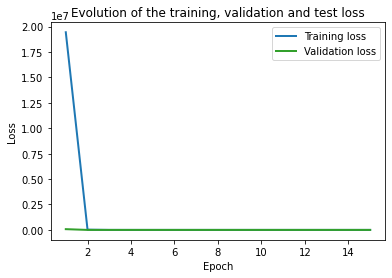

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.89s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 20.89it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 7 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.31 train_acc: 7.81% took: 4.03s
Epoch 1 of 15, 12% 	 train_loss: 361147232.00 train_acc: 14.06% took: 0.06s
Epoch 1 of 15, 18% 	 train_loss: 48474288.00 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 94816304.00 train_acc: 4.69% took: 0.07s
Epoch 1 of 15, 31% 	 train_loss: 86562160.00 train_acc: 17.19% took: 0.08s
Epoch 1 of 15, 37% 	 train_loss: 46475192.00 train_acc: 9.38% took: 0.06s
Epoch 1 of 15, 43% 	 train_loss: 36812164.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 11957599.00 train_acc: 4.69% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 1882137.00 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 1301502.62 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 372845.62 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 323266.62 train_acc: 4.69% took: 0.04s
Epoch

val_loss = 2.48 val_acc = 8.80%
Snapshot saved at epoch 7.
Epoch 8 of 15, 6% 	 train_loss: 2.58 train_acc: 14.06% took: 4.22s
Epoch 8 of 15, 12% 	 train_loss: 2.60 train_acc: 7.81% took: 0.05s
Epoch 8 of 15, 18% 	 train_loss: 2.61 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 25% 	 train_loss: 2.85 train_acc: 9.38% took: 0.06s
Epoch 8 of 15, 31% 	 train_loss: 2.76 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 37% 	 train_loss: 2.83 train_acc: 6.25% took: 0.06s
Epoch 8 of 15, 43% 	 train_loss: 2.71 train_acc: 9.38% took: 0.06s
Epoch 8 of 15, 50% 	 train_loss: 2.51 train_acc: 17.19% took: 0.05s
Epoch 8 of 15, 56% 	 train_loss: 2.67 train_acc: 4.69% took: 0.05s
Epoch 8 of 15, 62% 	 train_loss: 3.11 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 68% 	 train_loss: 2.74 train_acc: 7.81% took: 0.05s
Epoch 8 of 15, 75% 	 train_loss: 2.57 train_acc: 4.69% took: 0.05s
Epoch 8 of 15, 81% 	 train_loss: 3.07 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.62 train_acc: 4.69% took: 0.04s
Ep

Epoch 15 of 15, 31% 	 train_loss: 2.86 train_acc: 4.69% took: 0.07s
Epoch 15 of 15, 37% 	 train_loss: 3.12 train_acc: 6.25% took: 0.07s
Epoch 15 of 15, 43% 	 train_loss: 3.29 train_acc: 9.38% took: 0.06s
Epoch 15 of 15, 50% 	 train_loss: 2.89 train_acc: 17.19% took: 0.07s
Epoch 15 of 15, 56% 	 train_loss: 2.67 train_acc: 10.94% took: 0.07s
Epoch 15 of 15, 62% 	 train_loss: 3.61 train_acc: 9.38% took: 0.08s
Epoch 15 of 15, 68% 	 train_loss: 3.04 train_acc: 7.81% took: 0.06s
Epoch 15 of 15, 75% 	 train_loss: 2.75 train_acc: 14.06% took: 0.05s
Epoch 15 of 15, 81% 	 train_loss: 3.45 train_acc: 4.69% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 2.78 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.94 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 3.06 train_acc: 12.50% took: 0.03s
val_loss = 2.82 val_acc = 10.80%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


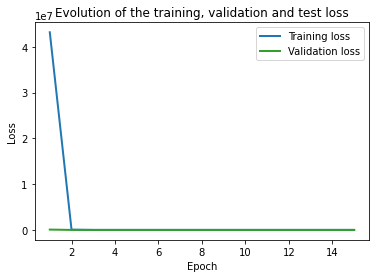

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.21s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.10it/s]


Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 107947241.16 train_acc: 10.16% took: 3.55s
Epoch 1 of 15, 16% 	 train_loss: 64173895.00 train_acc: 11.72% took: 0.08s
Epoch 1 of 15, 25% 	 train_loss: 46800435.00 train_acc: 11.72% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 26966471.00 train_acc: 7.03% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 12066300.00 train_acc: 7.03% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 2696092.09 train_acc: 6.25% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 59888.55 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 1338944.06 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 14.73 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 24893.06 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 60728.30 train_acc: 8.59% took: 0.08s
Epoch 1 of 15, 100% 	 tr

Epoch 10 of 15, 25% 	 train_loss: 2.57 train_acc: 15.62% took: 0.13s
Epoch 10 of 15, 33% 	 train_loss: 2.44 train_acc: 11.72% took: 0.13s
Epoch 10 of 15, 41% 	 train_loss: 2.71 train_acc: 7.81% took: 0.15s
Epoch 10 of 15, 50% 	 train_loss: 2.64 train_acc: 9.38% took: 0.15s
Epoch 10 of 15, 58% 	 train_loss: 2.52 train_acc: 5.47% took: 0.11s
Epoch 10 of 15, 66% 	 train_loss: 2.78 train_acc: 7.03% took: 0.09s
Epoch 10 of 15, 75% 	 train_loss: 2.70 train_acc: 8.59% took: 0.09s
Epoch 10 of 15, 83% 	 train_loss: 2.64 train_acc: 10.94% took: 0.08s
Epoch 10 of 15, 91% 	 train_loss: 2.79 train_acc: 8.59% took: 0.08s
Epoch 10 of 15, 100% 	 train_loss: 2.54 train_acc: 8.48% took: 0.06s
val_loss = 2.91 val_acc = 8.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.68 train_acc: 9.38% took: 4.21s
Epoch 11 of 15, 16% 	 train_loss: 2.68 train_acc: 8.59% took: 0.13s
Epoch 11 of 15, 25% 	 train_loss: 2.60 train_acc: 8.59% took: 0.12s
Epoch 11 of 15, 33% 	 train_loss: 2.40 train_acc: 11.

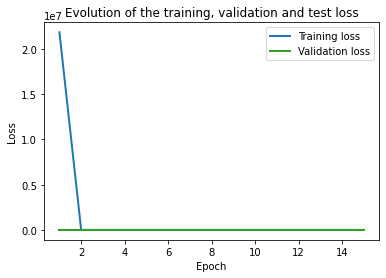

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:01<00:00,  4.07s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.04it/s]


Finished computing marginal prediction sets for 500 test points.

Starting repetition 8 of 10:

Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.31 train_acc: 10.94% took: 4.90s
Epoch 1 of 15, 12% 	 train_loss: 187781168.00 train_acc: 6.25% took: 0.06s
Epoch 1 of 15, 18% 	 train_loss: 38283864.00 train_acc: 9.38% took: 0.06s
Epoch 1 of 15, 25% 	 train_loss: 62440376.00 train_acc: 9.38% took: 0.05s
Epoch 1 of 15, 31% 	 train_loss: 86598576.00 train_acc: 6.25% took: 0.06s
Epoch 1 of 15, 37% 	 train_loss: 28118614.00 train_acc: 12.50% took: 0.06s
Epoch 1 of 15, 43% 	 train_loss: 9581616.00 train_acc: 12.50% took: 0.05s
Epoch 1 of 15, 50% 	 train_loss: 8352176.00 train_acc: 12.50% took: 0.05s
Epoch 1 of 15, 56% 	 train_loss: 5591783.00 train_acc: 12.50% took: 0.06s
Epoch 1 of 15, 62% 	 train_loss: 1355559.50 train_acc: 6.25% took: 0.06s
Epoch 1 of 15, 68% 	 train_loss: 258790.75 train_acc: 1

val_loss = 2.70 val_acc = 9.20%
Snapshot saved at epoch 7.
Epoch 8 of 15, 6% 	 train_loss: 2.66 train_acc: 12.50% took: 3.75s
Epoch 8 of 15, 12% 	 train_loss: 2.71 train_acc: 15.62% took: 0.04s
Epoch 8 of 15, 18% 	 train_loss: 2.66 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 25% 	 train_loss: 2.40 train_acc: 15.62% took: 0.04s
Epoch 8 of 15, 31% 	 train_loss: 2.79 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 37% 	 train_loss: 2.49 train_acc: 6.25% took: 0.04s
Epoch 8 of 15, 43% 	 train_loss: 2.70 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 50% 	 train_loss: 2.74 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 56% 	 train_loss: 2.69 train_acc: 9.38% took: 0.03s
Epoch 8 of 15, 62% 	 train_loss: 2.72 train_acc: 6.25% took: 0.03s
Epoch 8 of 15, 68% 	 train_loss: 2.51 train_acc: 12.50% took: 0.03s
Epoch 8 of 15, 75% 	 train_loss: 2.60 train_acc: 10.94% took: 0.03s
Epoch 8 of 15, 81% 	 train_loss: 2.60 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.40 train_acc: 12.50% took: 0

Epoch 15 of 15, 31% 	 train_loss: 2.43 train_acc: 6.25% took: 0.05s
Epoch 15 of 15, 37% 	 train_loss: 2.50 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 43% 	 train_loss: 2.63 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 50% 	 train_loss: 2.66 train_acc: 10.94% took: 0.05s
Epoch 15 of 15, 56% 	 train_loss: 2.65 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 2.45 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 2.84 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 2.52 train_acc: 15.62% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 2.49 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 2.35 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.64 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.50 train_acc: 15.00% took: 0.03s
val_loss = 2.53 val_acc = 12.00%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


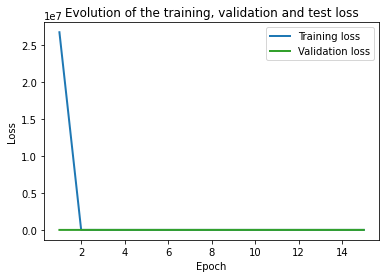

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.96s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.02it/s]


Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 63046013.15 train_acc: 11.72% took: 3.81s
Epoch 1 of 15, 16% 	 train_loss: 83707542.00 train_acc: 5.47% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 44497821.00 train_acc: 11.72% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 35595688.50 train_acc: 8.59% took: 0.08s
Epoch 1 of 15, 41% 	 train_loss: 6468152.75 train_acc: 8.59% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 3382844.56 train_acc: 11.72% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 231891.91 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 127771.92 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 158437.77 train_acc: 7.03% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 16.55 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 6001.83 train_acc: 5.47% took: 0.08s
Epoch 1 of 15, 100% 	 tr

Epoch 10 of 15, 25% 	 train_loss: 2.66 train_acc: 13.28% took: 0.09s
Epoch 10 of 15, 33% 	 train_loss: 2.67 train_acc: 9.38% took: 0.09s
Epoch 10 of 15, 41% 	 train_loss: 2.69 train_acc: 7.03% took: 0.09s
Epoch 10 of 15, 50% 	 train_loss: 2.88 train_acc: 6.25% took: 0.09s
Epoch 10 of 15, 58% 	 train_loss: 2.67 train_acc: 12.50% took: 0.08s
Epoch 10 of 15, 66% 	 train_loss: 2.84 train_acc: 7.03% took: 0.08s
Epoch 10 of 15, 75% 	 train_loss: 2.66 train_acc: 14.06% took: 0.08s
Epoch 10 of 15, 83% 	 train_loss: 2.73 train_acc: 9.38% took: 0.08s
Epoch 10 of 15, 91% 	 train_loss: 2.93 train_acc: 5.47% took: 0.07s
Epoch 10 of 15, 100% 	 train_loss: 3.13 train_acc: 8.48% took: 0.06s
val_loss = 2.53 val_acc = 13.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.58 train_acc: 11.72% took: 4.17s
Epoch 11 of 15, 16% 	 train_loss: 2.76 train_acc: 11.72% took: 0.11s
Epoch 11 of 15, 25% 	 train_loss: 2.70 train_acc: 13.28% took: 0.08s
Epoch 11 of 15, 33% 	 train_loss: 2.65 train_acc:

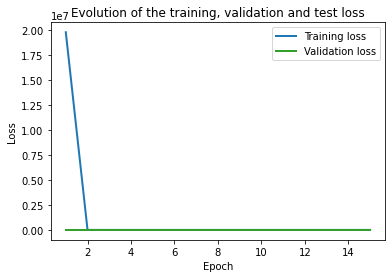

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.88s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.35it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 9 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.32 train_acc: 6.25% took: 3.59s
Epoch 1 of 15, 12% 	 train_loss: 121136960.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 18% 	 train_loss: 29844616.00 train_acc: 7.81% took: 0.03s
Epoch 1 of 15, 25% 	 train_loss: 91067504.00 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 54444780.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 37% 	 train_loss: 17474422.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 21713640.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 25366436.00 train_acc: 14.06% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 9120503.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 6084206.50 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 4689885.50 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 1735957.50 train_acc: 12.50% took: 0.04s
Epoch 

val_loss = 444.02 val_acc = 9.00%
Snapshot saved at epoch 7.
Epoch 8 of 15, 6% 	 train_loss: 2.61 train_acc: 12.50% took: 4.25s
Epoch 8 of 15, 12% 	 train_loss: 2.79 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 18% 	 train_loss: 2.64 train_acc: 15.62% took: 0.05s
Epoch 8 of 15, 25% 	 train_loss: 2.42 train_acc: 15.62% took: 0.06s
Epoch 8 of 15, 31% 	 train_loss: 2.54 train_acc: 12.50% took: 0.06s
Epoch 8 of 15, 37% 	 train_loss: 2.62 train_acc: 17.19% took: 0.05s
Epoch 8 of 15, 43% 	 train_loss: 2.87 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 50% 	 train_loss: 2.58 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 56% 	 train_loss: 2.71 train_acc: 10.94% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.92 train_acc: 6.25% took: 0.06s
Epoch 8 of 15, 68% 	 train_loss: 2.66 train_acc: 14.06% took: 0.05s
Epoch 8 of 15, 75% 	 train_loss: 2.76 train_acc: 12.50% took: 0.05s
Epoch 8 of 15, 81% 	 train_loss: 2.77 train_acc: 9.38% took: 0.05s
Epoch 8 of 15, 87% 	 train_loss: 2.57 train_acc: 10.94% took

Epoch 15 of 15, 37% 	 train_loss: 2.79 train_acc: 17.19% took: 0.05s
Epoch 15 of 15, 43% 	 train_loss: 3.00 train_acc: 7.81% took: 0.06s
Epoch 15 of 15, 50% 	 train_loss: 2.65 train_acc: 9.38% took: 0.06s
Epoch 15 of 15, 56% 	 train_loss: 2.97 train_acc: 10.94% took: 0.06s
Epoch 15 of 15, 62% 	 train_loss: 3.03 train_acc: 10.94% took: 0.06s
Epoch 15 of 15, 68% 	 train_loss: 2.72 train_acc: 10.94% took: 0.05s
Epoch 15 of 15, 75% 	 train_loss: 2.76 train_acc: 12.50% took: 0.06s
Epoch 15 of 15, 81% 	 train_loss: 3.03 train_acc: 9.38% took: 0.05s
Epoch 15 of 15, 87% 	 train_loss: 2.75 train_acc: 10.94% took: 0.05s
Epoch 15 of 15, 93% 	 train_loss: 2.84 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 3.00 train_acc: 2.50% took: 0.04s
val_loss = 443.79 val_acc = 9.00%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


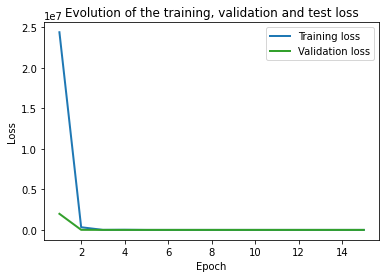

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.41s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 22.97it/s]

Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...


===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 114697865.15 train_acc: 14.06% took: 3.57s
Epoch 1 of 15, 16% 	 train_loss: 65693490.00 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 82327614.00 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 20540605.00 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 10997757.75 train_acc: 18.75% took: 0.07s
Epoch 1 of 15, 50% 	 train_loss: 2425883.25 train_acc: 7.03% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 1994700.97 train_acc: 8.59% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 432631.61 train_acc: 10.94% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 383431.76 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 114902.40 train_acc: 7.81% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 10515.58 train_acc: 8.59% took: 0.07s
Epoch 1 of 15, 100% 	 train_loss: 66196.08 train_acc: 9.26% took: 0.07s
val_loss = 16505.61 val_acc = 10.00%
Snapshot 

Epoch 10 of 15, 33% 	 train_loss: 2.63 train_acc: 11.72% took: 0.07s
Epoch 10 of 15, 41% 	 train_loss: 2.95 train_acc: 5.47% took: 0.07s
Epoch 10 of 15, 50% 	 train_loss: 2.69 train_acc: 9.38% took: 0.07s
Epoch 10 of 15, 58% 	 train_loss: 2.86 train_acc: 12.50% took: 0.07s
Epoch 10 of 15, 66% 	 train_loss: 2.81 train_acc: 7.03% took: 0.07s
Epoch 10 of 15, 75% 	 train_loss: 2.53 train_acc: 10.94% took: 0.07s
Epoch 10 of 15, 83% 	 train_loss: 2.70 train_acc: 11.72% took: 0.07s
Epoch 10 of 15, 91% 	 train_loss: 2.56 train_acc: 8.59% took: 0.07s
Epoch 10 of 15, 100% 	 train_loss: 2.76 train_acc: 8.26% took: 0.06s
val_loss = 2.44 val_acc = 11.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.61 train_acc: 8.59% took: 3.51s
Epoch 11 of 15, 16% 	 train_loss: 2.63 train_acc: 8.59% took: 0.07s
Epoch 11 of 15, 25% 	 train_loss: 2.52 train_acc: 9.38% took: 0.06s
Epoch 11 of 15, 33% 	 train_loss: 2.62 train_acc: 11.72% took: 0.06s
Epoch 11 of 15, 41% 	 train_loss: 2.93 train_acc: 

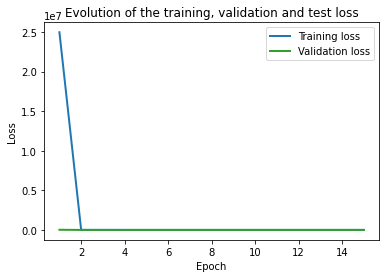

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:06<00:00,  4.42s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.38it/s]

Finished computing marginal prediction sets for 500 test points.

Starting repetition 10 of 10:



Training with standard data splitting...
===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 6% 	 train_loss: 2.30 train_acc: 12.50% took: 3.59s
Epoch 1 of 15, 12% 	 train_loss: 176433040.00 train_acc: 15.62% took: 0.04s
Epoch 1 of 15, 18% 	 train_loss: 65688028.00 train_acc: 3.12% took: 0.03s
Epoch 1 of 15, 25% 	 train_loss: 45065756.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 31% 	 train_loss: 92302832.00 train_acc: 1.56% took: 0.04s
Epoch 1 of 15, 37% 	 train_loss: 45480108.00 train_acc: 9.38% took: 0.04s
Epoch 1 of 15, 43% 	 train_loss: 21838626.00 train_acc: 10.94% took: 0.04s
Epoch 1 of 15, 50% 	 train_loss: 4525892.00 train_acc: 7.81% took: 0.04s
Epoch 1 of 15, 56% 	 train_loss: 639071.12 train_acc: 6.25% took: 0.04s
Epoch 1 of 15, 62% 	 train_loss: 386186.28 train_acc: 1.56% took: 0.04s
Epoch 1 of 15, 68% 	 train_loss: 50093.09 train_acc: 12.50% took: 0.04s
Epoch 1 of 15, 75% 	 train_loss: 175838.12 train_acc: 12.50% took: 0.04s
Epoch 1 o

Epoch 8 of 15, 6% 	 train_loss: 2.70 train_acc: 10.94% took: 3.96s
Epoch 8 of 15, 12% 	 train_loss: 2.92 train_acc: 7.81% took: 0.03s
Epoch 8 of 15, 18% 	 train_loss: 3.01 train_acc: 15.62% took: 0.03s
Epoch 8 of 15, 25% 	 train_loss: 2.80 train_acc: 12.50% took: 0.04s
Epoch 8 of 15, 31% 	 train_loss: 2.63 train_acc: 20.31% took: 0.04s
Epoch 8 of 15, 37% 	 train_loss: 3.00 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 43% 	 train_loss: 3.08 train_acc: 7.81% took: 0.03s
Epoch 8 of 15, 50% 	 train_loss: 2.80 train_acc: 14.06% took: 0.03s
Epoch 8 of 15, 56% 	 train_loss: 2.62 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 62% 	 train_loss: 2.77 train_acc: 14.06% took: 0.04s
Epoch 8 of 15, 68% 	 train_loss: 3.26 train_acc: 4.69% took: 0.04s
Epoch 8 of 15, 75% 	 train_loss: 2.92 train_acc: 14.06% took: 0.03s
Epoch 8 of 15, 81% 	 train_loss: 2.84 train_acc: 9.38% took: 0.04s
Epoch 8 of 15, 87% 	 train_loss: 2.88 train_acc: 7.81% took: 0.04s
Epoch 8 of 15, 93% 	 train_loss: 2.75 train_acc: 10.94% 

Epoch 15 of 15, 31% 	 train_loss: 2.94 train_acc: 4.69% took: 0.05s
Epoch 15 of 15, 37% 	 train_loss: 2.98 train_acc: 10.94% took: 0.04s
Epoch 15 of 15, 43% 	 train_loss: 3.11 train_acc: 7.81% took: 0.04s
Epoch 15 of 15, 50% 	 train_loss: 3.07 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 56% 	 train_loss: 2.58 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 62% 	 train_loss: 2.90 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 68% 	 train_loss: 3.37 train_acc: 4.69% took: 0.04s
Epoch 15 of 15, 75% 	 train_loss: 3.11 train_acc: 6.25% took: 0.04s
Epoch 15 of 15, 81% 	 train_loss: 3.07 train_acc: 9.38% took: 0.04s
Epoch 15 of 15, 87% 	 train_loss: 3.05 train_acc: 12.50% took: 0.04s
Epoch 15 of 15, 93% 	 train_loss: 2.90 train_acc: 14.06% took: 0.04s
Epoch 15 of 15, 100% 	 train_loss: 2.92 train_acc: 10.00% took: 0.03s
val_loss = 2.96 val_acc = 11.20%
Snapshot saved at epoch 15.
Training done! A list of 15 models saved.


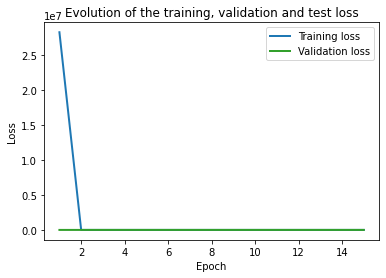

Computing standard benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:03<00:00,  4.22s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.32it/s]

Finished computing marginal prediction sets for 500 test points.
Training with CES data splitting...


===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 15
learning_rate= 10
Epoch 1 of 15, 8% 	 train_loss: 89515593.15 train_acc: 11.72% took: 3.46s
Epoch 1 of 15, 16% 	 train_loss: 62909608.00 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 25% 	 train_loss: 122436412.00 train_acc: 6.25% took: 0.07s
Epoch 1 of 15, 33% 	 train_loss: 18587624.50 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 41% 	 train_loss: 30053824.00 train_acc: 12.50% took: 0.08s
Epoch 1 of 15, 50% 	 train_loss: 1872953.72 train_acc: 14.06% took: 0.07s
Epoch 1 of 15, 58% 	 train_loss: 210009.61 train_acc: 10.16% took: 0.07s
Epoch 1 of 15, 66% 	 train_loss: 182598.32 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 75% 	 train_loss: 362.19 train_acc: 14.84% took: 0.07s
Epoch 1 of 15, 83% 	 train_loss: 88.82 train_acc: 12.50% took: 0.07s
Epoch 1 of 15, 91% 	 train_loss: 17201.79 train_acc: 9.38% took: 0.07s
Epoch 1 of 15, 100% 	 train_loss: 22863.42 train_acc: 4.13% took: 0.07s
val_loss = 14.37 val_acc = 6.00%
Snapshot saved at

Epoch 10 of 15, 33% 	 train_loss: 2.76 train_acc: 6.25% took: 0.08s
Epoch 10 of 15, 41% 	 train_loss: 2.67 train_acc: 10.16% took: 0.08s
Epoch 10 of 15, 50% 	 train_loss: 2.68 train_acc: 14.06% took: 0.08s
Epoch 10 of 15, 58% 	 train_loss: 2.53 train_acc: 7.81% took: 0.08s
Epoch 10 of 15, 66% 	 train_loss: 2.59 train_acc: 13.28% took: 0.08s
Epoch 10 of 15, 75% 	 train_loss: 2.52 train_acc: 7.81% took: 0.08s
Epoch 10 of 15, 83% 	 train_loss: 2.59 train_acc: 12.50% took: 0.08s
Epoch 10 of 15, 91% 	 train_loss: 2.46 train_acc: 14.06% took: 0.08s
Epoch 10 of 15, 100% 	 train_loss: 2.72 train_acc: 9.60% took: 0.07s
val_loss = 2.50 val_acc = 9.00%
Snapshot saved at epoch 10.
Epoch 11 of 15, 8% 	 train_loss: 2.79 train_acc: 7.03% took: 4.22s
Epoch 11 of 15, 16% 	 train_loss: 2.92 train_acc: 12.50% took: 0.11s
Epoch 11 of 15, 25% 	 train_loss: 2.70 train_acc: 6.25% took: 0.09s
Epoch 11 of 15, 33% 	 train_loss: 2.72 train_acc: 6.25% took: 0.08s
Epoch 11 of 15, 41% 	 train_loss: 2.67 train_acc: 

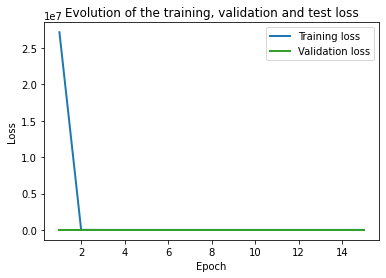

Computing naive benchmark prediction sets for 500 test points...
Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.91s/it]


Initialization done!


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.24it/s]


Finished computing marginal prediction sets for 500 test points.


In [7]:
# Define the model parameters
n_train_bm = 1000
n_val_bm = 500
n_cal_bm = 100
n_test = 500
lr = 10
alpha = 0.1
n_epoch = 15
n_classes = len(classes)
num_repetitions = 10

def add_header(df):
    df["Alpha"] = alpha
    df["n_epoch"] = n_epoch
    df["n_calib"] = n_cal_bm
    return df

results = pd.DataFrame({})
for r in range(num_repetitions):
    print("\nStarting repetition {:d} of {:d}:\n".format(r+1, num_repetitions))
    sys.stdout.flush()
    
    # Change random seed for this repetition
    seed = r
    results_new = run_experiment(seed, n_classes, n_train_bm, n_val_bm, n_cal_bm, n_test, lr, n_epoch, alpha)
    results_new = add_header(results_new)
    results_new["Repetition"] = r
    results = pd.concat([results, results_new])

In [8]:
results

,M-coverage,M-size,M-size|cov,Method,Alpha,n_epoch,n_calib,Repetition
0,0.914,9.114,9.124726,Standard benchmark,0.1,15,100,0
0,0.938,9.354,9.377399,Naive benchmark,0.1,15,100,0
0,0.866,8.884,8.916859,Standard benchmark,0.1,15,100,1
0,0.938,9.368,9.392324,Naive benchmark,0.1,15,100,1
0,0.906,8.868,8.889625,Standard benchmark,0.1,15,100,2
0,0.862,8.616,8.777262,Naive benchmark,0.1,15,100,2
0,0.904,8.778,8.796460,Standard benchmark,0.1,15,100,3
0,0.854,8.450,8.512881,Naive benchmark,0.1,15,100,3
0,0.872,8.816,8.853211,Standard benchmark,0.1,15,100,4
0,0.904,8.890,8.902655,Naive benchmark,0.1,15,100,4


In [9]:
test = pd.DataFrame({})

In [10]:
test["S"] = [1]


In [11]:
test

,S
0,1
